In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm

from CRDDM.Models import HSDM

import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution as DE

# Simulation:

In [2]:
threshold = 2
drift_vector = np.array([3, 2, 1, 0])
ndt = 0.3

df = HSDM.rng(threshold, drift_vector, ndt, n_sample=1000)

In [3]:
df

,rt,response1,response2,response3
0,0.718,0.382479,0.276643,3.055838
1,0.713,1.084215,1.263079,0.030226
2,0.683,0.487572,1.152183,-1.295238
3,0.707,0.599788,1.438084,-0.515447
4,0.823,1.142671,0.567902,1.400184
...,...,...,...,...
995,0.609,0.825208,0.927958,-0.101929
996,1.162,0.845441,1.277785,-0.667621
997,0.796,0.593865,0.605180,0.059390
998,1.301,0.507165,0.904912,-0.893330


In [4]:
# plt.figure(figsize=(9, 4), layout='constrained')
# plt.subplot(121)
# t = np.linspace(0.01, df['rt'].max(), 200)
# plt.plot(t+ndt, SDM.response_time_pdf(t, threshold, drift_vector), color='red')
# sns.histplot(df['rt'], stat='density');

# plt.subplot(122)
# theta = np.linspace(-3.14, 3.14, 200)
# plt.plot(theta, SDM.response_pdf(theta, threshold, drift_vector), color='red')
# sns.histplot(df['response'], stat='density');

# Parameter recovery:

In [5]:
def fit_hsdm(prms, rt, theta):
    threshold =  prms[0] # decision threshold
    ndt = prms[1] # non-decision time
    drift_vec = np.array([prms[2], prms[3], prms[4], prms[5]]) # drift vector
    s_v = 0 #prms[4]
    
    return -np.sum(HSDM.joint_lpdf(rt, theta, threshold, drift_vec, ndt, s_v=s_v))

In [6]:
n_trials = 300
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu_x_true': [],
               'mu_x_estimate': [],
               'mu_y_true': [],
               'mu_y_estimate': [],
               'mu_z_true':[],
               'mu_z_estimate': [],
               'mu_w_true':[],
               'mu_w_estimate': []}

# These are the bounds for parameter estimation
min_threshold = 0.05
max_threshold = 5

min_ndt = 0
max_ndt = 2

min_mu = -5
max_mu = 5

prms_bounds = [(min_threshold, max_threshold), (min_ndt, max_ndt),
               (min_mu, max_mu), (min_mu, max_mu), 
               (min_mu, max_mu), (min_mu, max_mu)]

In [7]:
for n in tqdm(range(100)):
    # generating some random parameters
    threshold = np.random.uniform(0.5, max_threshold)
    mu_x = np.random.uniform(min_mu, max_mu)
    mu_y = np.random.uniform(min_mu, max_mu)
    mu_z = np.random.uniform(min_mu, max_mu)
    mu_w = np.random.uniform(min_mu, max_mu)
    drift_vector = np.array([mu_x, mu_y, mu_z, mu_w])
    ndt = np.random.uniform(0.05, max_ndt)
    
    sim_df = HSDM.rng(threshold, drift_vector, ndt, s_v=0, n_sample=n_trials)
    
    # Estimating the paramters for the simulated data
    min_ans = DE(fit_hsdm, args=(sim_df['rt'].values, sim_df[['response1', 'response2', 'response3']].values), 
                 bounds=prms_bounds)

    
    # Storing the true generating parameters
    recovery_df['threshold_true'].append(threshold)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu_x_true'].append(mu_x)
    recovery_df['mu_y_true'].append(mu_y)
    recovery_df['mu_z_true'].append(mu_z)
    recovery_df['mu_w_true'].append(mu_w)
    
    # Stroing the estimated parameters
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['ndt_estimate'].append(min_ans.x[1])
    recovery_df['mu_x_estimate'].append(min_ans.x[2])
    recovery_df['mu_y_estimate'].append(min_ans.x[3])
    recovery_df['mu_z_estimate'].append(min_ans.x[4])
    recovery_df['mu_w_estimate'].append(min_ans.x[5])

100%|█████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


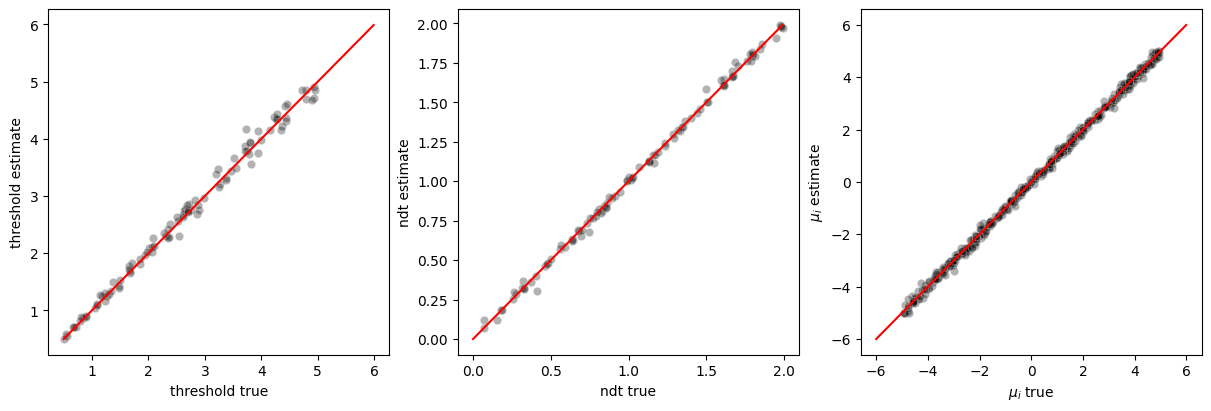

In [8]:
plt.figure(figsize=(12, 4), layout='constrained')

plt.subplot(131)
plt.plot(np.arange(.5, 6, 0.01), np.arange(.5, 6, 0.01), c='red')
sns.scatterplot(x='threshold_true', y='threshold_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'threshold true')
plt.ylabel(r'threshold estimate')

plt.subplot(132)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'ndt true')
plt.ylabel(r'ndt estimate')

plt.subplot(133)
plt.plot(np.arange(-6, 6, 0.01), np.arange(-6, 6, 0.01), c='red')
sns.scatterplot(x='mu_x_true', y='mu_x_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_y_true', y='mu_y_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_z_true', y='mu_z_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_w_true', y='mu_w_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'$\mu_i$ true')
plt.ylabel(r'$\mu_i$ estimate');
